In [59]:
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.special as sp

# Such that backgrounds of plots are white and not transparent
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

import numpy as np
import pandas as pd

fs = 16


In [60]:
def printnum(itext, nums, ftext = ''):
    txt = itext
    try:
        iter(nums)
    except TypeError:
        nums = [nums]
    for i,num in enumerate(nums):
        txt += '{:.2f}'.format(num)
        if i < (len(nums)-1):
            txt += ', '
    txt += ' ' + ftext
    print(txt)
    
# Parameters
sigz = np.array([220, 260, 300])*1e-6
sigz = np.mean(sigz)  # for simplicity just take one value of bunch length
sigr_line = 0.4e-3
sigr_wide = 2.5e-3
printnum('sigr = ', np.array([sigr_line, sigr_wide]) * 1e3, 'mm')
K = 10.81
E = np.array([43,63])
printnum("E = ", E, 'MeV')
gamma = E * 1/.511
printnum("gamma = ", gamma)
gamma0 = gamma / np.sqrt(1 + .5 * K**2)
printnum("gamma0 = ", gamma0)
lw = 8.5e-2
lr = lw / 2 / gamma0**2
printnum("lambda_r = ", lr * 1e6, "mum")
sig_diff = np.sqrt(lw/2/np.pi*sigz)
printnum("sigma_diff = sqrt(lw,sigz) = ", sig_diff * 1e3, "mm")
sig_SC = gamma0 * sigz
printnum("sig_SC = gamma0 * sigz = ", sig_SC * 1e3, "mm")
eta_line = gamma0 *  sigz  / sigr_line
eta_wide = gamma0 *  sigz  / sigr_wide
printnum("eta_line = ", eta_line)
printnum("eta_wide = ", eta_wide)
p_line =  sigz * gamma0**2 / lw * 2 * np.pi
printnum("p = ", p_line)



sigr = 0.40, 2.50 mm
E = 43.00, 63.00 MeV
gamma = 84.15, 123.29 
gamma0 = 10.92, 15.99 
lambda_r = 356.69, 166.17 mum
sigma_diff = sqrt(lw,sigz) = 1.88 mm
sig_SC = gamma0 * sigz = 2.84, 4.16 mm
eta_line = 7.10, 10.40 
eta_wide = 1.14, 1.66 
p = 2.29, 4.92 


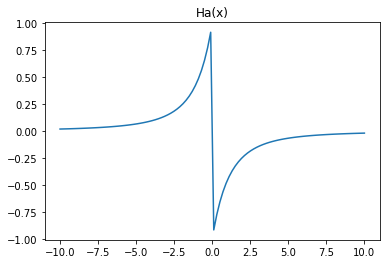

In [63]:
# Wake function thick beam drift/wiggler from Geloni 2007

def Ha(x):
    if x == 0:
        return 1
    else:
        t1 = 2 * np.sqrt(np.pi) / np.abs(x)
    # erfc = sp.erfc(np.abs(x)/2)
    # t2 = np.pi * np.exp(x**2/4) * erfc
    t2 = np.pi * sp.erfcx(np.abs(x)/2)
    fact = x / 2 / np.sqrt(np.pi)
    return -fact * (t1 - t2)


x = np.linspace(-10,10,100)
plt.title("Ha(x)")
plt.plot(x, [Ha(xi) for xi in x])
plt.show()



1 1.0 1.0


4 3.699273910159951 2.0


10 6.355345937795136 3.1622776601683795


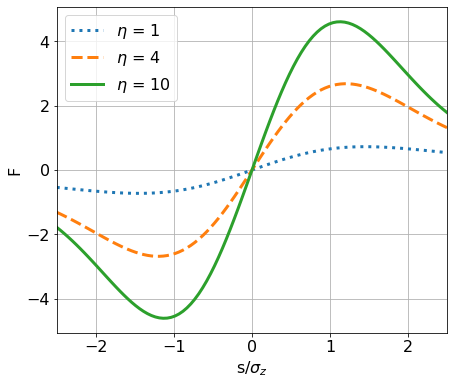

In [71]:
def F(sh,eta):
    inf = 3*eta
    x = np.linspace(-inf,inf,100)
    y = [f(xi,sh,eta) for xi in x]
    return - integrate.quad(f,-inf, inf, args = (sh,eta))[0]

    
def f(x,sh,eta):
    return eta * Ha(eta*sh - x) * np.exp(-x**2/(2*eta**2))

shs = np.linspace(-2.5, 2.5,100)
etas = [1,4,10,100]
lss = [':', '--','-']
fig, ax = plt.subplots(figsize = (7,6))
for i,eta in enumerate(etas):
    y = [F(sh,eta) for sh in shs]
    if i == 0:
        y0 = np.max(y)
    ax.plot(shs, y, ls = lss[i], lw = 3)
    print(eta, np.max(y) / y0, np.sqrt(eta))
ax.legend(["$\eta$ = " + str(eta) for eta in etas], fontsize = fs)
ax.tick_params(axis = 'both', labelsize = fs)
ax.set_xlabel("s/$\sigma_z$", fontsize = fs)
ax.set_ylabel("F", fontsize = fs)
ax.set_xlim([-2.5, 2.5])
ax.grid()

# plt.savefig("wakefunction.eps")
plt.show()

In [80]:
# F_mod includes K. So dE = factor_withoutK * F(s,eta_withoutK,K)
def F_mod(sh,eta,K):
    return (1 + K**2/2) * F(sh,eta / np.sqrt(1 + K**2/2))

shs = np.linspace(-2.5, 2.5,100)
eta = 10
Ks = [0,1,10,50]

fig, ax = plt.subplots(figsize = (7,6))
for i,K in enumerate(Ks):
    y = [F_mod(sh,eta,K) for sh in shs]
    if i == 0:
        y0 = np.max(y)
    ax.plot(shs, y, lw = 3)
    print(np.max(y)/y0, "K = ", K)
ax.legend(["K = " + str(K) for K in Ks], fontsize = fs)
ax.tick_params(axis = 'both', labelsize = fs)
ax.set_xlabel("s/$\sigma_z$", fontsize = fs)
ax.set_ylabel("F", fontsize = fs)
ax.set_xlim([-2.5, 2.5])
ax.grid()

plt.show()

1.0 K =  0


1.3532593925977143 K =  1


11.756544818597856 K =  10


32.83465991498845 K =  50


In [26]:
# Wake function line charge, from Saldin 1998
def F_line(x, C = 0.577):
    term1 = 1/4 * (C + 3*np.log(2) - 2) * x * np.exp(-x**2/2)
    func = lambda y: np.exp(y**2/2) * (1 + sp.erf(y/np.sqrt(2)))
    integral = integrate.quad(func, 0, x)[0]
    term2 = -np.sqrt(np.pi/8) * (1 + sp.erf(x/np.sqrt(2)) - x * np.exp(-x**2/2) * integral)
    return term1 + term2

x = np.linspace(-4,4,100)
plt.plot(x, [F_line(xi) for xi in x])
plt.grid()
plt.show()


p =  [2.29001286 4.91566309]


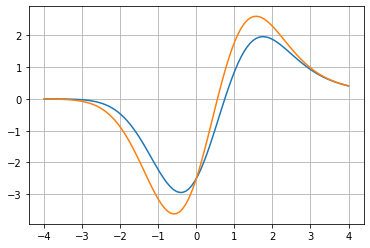

In [70]:
g = 1 - np.log(1 + .5 * K**2) / (.5 * K**2)
def G_line(x,p):
    return x/2 * np.exp(-x**2/2) * (np.log(p) + g) + F_line(x)

x = np.linspace(-4,4,100)
p = sigz * gamma0**2 / lw * 2 * np.pi
print("p = ", p)
plt.plot(x, [4*G_line(xi,p) for xi in x])
plt.grid()
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


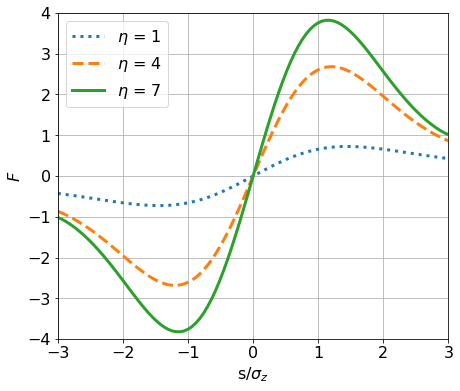

In [78]:
shs = np.linspace(-3, 3,100)
lss = [':', '--','-']
etas = [1,4,7]
ps = [2,5]

fig, ax = plt.subplots(figsize = (7,6))
for i,eta in enumerate(etas):
    ax.plot(shs, [F(sh,eta) for sh in shs], ls = lss[i], lw = 3)
ax.legend(["$\eta$ = " + str(eta) for eta in etas], fontsize = fs)
ax.tick_params(axis = 'both', labelsize = fs)
ax.set_xlabel("s/$\sigma_z$", fontsize = fs)
ax.set_ylabel("$F$", fontsize = fs)
ax.set_xlim([-3, 3])
ax.set_ylim([-4,4])
ax.grid()
plt.savefig("wakefunction.eps")

fig2, ax = plt.subplots(figsize = (7,6))
for i,p in enumerate(ps):
    ax.plot(shs, [4*F_line(sh,p) for sh in shs], ls = lss[i], lw = 3)    
ax.legend(["p = " + str(p) for p in ps], fontsize = fs)
ax.tick_params(axis = 'both', labelsize = fs)
ax.set_xlabel("s/$\sigma_z$", fontsize = fs)
ax.set_ylabel("$F_{line}$", fontsize = fs)
ax.set_xlim([-3,3])
ax.set_ylim([-4,4])
ax.grid()

plt.savefig("wakefunction_thin.eps")
plt.show()